##### Copyright 2019 The TensorFlow Authors.


In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# 用 tf.data 加载 CSV 数据

<table class="tfo-notebook-buttons" align="left">
  <td>     <a target="_blank" href="https://tensorflow.google.cn/tutorials/load_data/csv"><img src="https://tensorflow.google.cn/images/tf_logo_32px.png">在 TensorFlow.org 上查看</a> </td>
  <td><a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs-l10n/blob/master/site/zh-cn/tutorials/load_data/csv.ipynb"><img src="https://tensorflow.google.cn/images/colab_logo_32px.png">在 Google Colab 中运行</a></td>
  <td>     <a target="_blank" href="https://github.com/tensorflow/docs-l10n/blob/master/site/zh-cn/tutorials/load_data/csv.ipynb"><img src="https://tensorflow.google.cn/images/GitHub-Mark-32px.png">在 Github 上查看源代码</a> </td>
  <td>     <a href="https://storage.googleapis.com/tensorflow_docs/docs-l10n/site/zh-cn/tutorials/load_data/csv.ipynb"><img src="https://tensorflow.google.cn/images/download_logo_32px.png">下载笔记本</a>   </td>
</table>

本教程提供了如何在 TensorFlow 中使用 CSV 数据的示例。

其中包括两个主要部分：

1. **Loading the data off disk**
2. **Pre-processing it into a form suitable for training.**

本教程侧重于加载，并提供了一些关于预处理的快速示例。要了解有关预处理方面的更多信息，请查看[使用预处理层](https://tensorflow.google.cn/guide/keras/preprocessing_layers)指南和[使用 Keras 预处理层对结构化数据进行分类](../structured_data/preprocessing_layers.ipynb)教程。


## 设置

In [2]:
import pandas as pd
import numpy as np

# Make numpy values easier to read.
np.set_printoptions(precision=3, suppress=True)

import tensorflow as tf
from tensorflow.keras import layers

2023-11-07 23:47:13.690444: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-07 23:47:13.690500: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-07 23:47:13.692293: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## 内存数据

对于任何较小的 CSV 数据集，在其上训练 TensorFlow 模型的最简单方式是将其作为 Pandas Dataframe 或 NumPy 数组加载到内存中。


一个相对简单的示例是 [Abalone Dataset](https://archive.ics.uci.edu/ml/datasets/abalone)。

- 数据集很小。
- 所有输入特征都是有限范围的浮点值。

以下是将数据下载到 [Pandas `DataFrame`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html) 的方式：

In [3]:
abalone_train = pd.read_csv(
    "https://storage.googleapis.com/download.tensorflow.org/data/abalone_train.csv",
    names=["Length", "Diameter", "Height", "Whole weight", "Shucked weight",
           "Viscera weight", "Shell weight", "Age"])

abalone_train.head()

,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Age
0,0.435,0.335,0.110,0.334,0.1355,0.0775,0.0965,7
1,0.585,0.450,0.125,0.874,0.3545,0.2075,0.2250,6
2,0.655,0.510,0.160,1.092,0.3960,0.2825,0.3700,14
3,0.545,0.425,0.125,0.768,0.2940,0.1495,0.2600,16
4,0.545,0.420,0.130,0.879,0.3740,0.1695,0.2300,13


该数据集包含一组[鲍鱼](https://en.wikipedia.org/wiki/Abalone)（一种海螺）的测量值。

![an abalone shell](https://tensorflow.org/images/abalone_shell.jpg)

[“鲍鱼壳”](https://www.flickr.com/photos/thenickster/16641048623/)（作者：[Nicki Dugan Pogue](https://www.flickr.com/photos/thenickster/)，CC BY-SA 2.0）


此数据集的名义任务是根据其他测量值预测年龄，因此要把特征和标签分开以进行训练：


In [4]:
abalone_features = abalone_train.copy()
abalone_labels = abalone_features.pop('Age')

对于此数据集，将以相同的方式处理所有特征。将这些特征打包成单个 NumPy 数组：

In [5]:
abalone_features = np.array(abalone_features)
abalone_features

array([[0.435, 0.335, 0.11 , ..., 0.136, 0.077, 0.097],
       [0.585, 0.45 , 0.125, ..., 0.354, 0.207, 0.225],
       [0.655, 0.51 , 0.16 , ..., 0.396, 0.282, 0.37 ],
       ...,
       [0.53 , 0.42 , 0.13 , ..., 0.374, 0.167, 0.249],
       [0.395, 0.315, 0.105, ..., 0.118, 0.091, 0.119],
       [0.45 , 0.355, 0.12 , ..., 0.115, 0.067, 0.16 ]])

接下来，制作一个回归模型来预测年龄。由于只有一个输入张量，这里使用 `tf.keras.Sequential` 模型就足够了。

In [6]:
abalone_model = tf.keras.Sequential([
  layers.Dense(64),
  layers.Dense(1)
])

abalone_model.compile(loss = tf.keras.losses.MeanSquaredError(),
                      optimizer = tf.keras.optimizers.Adam())

要训练该模型，请将特征和标签传递给 `Model.fit`：

In [7]:
abalone_model.fit(abalone_features, abalone_labels, epochs=10)

Epoch 1/10


I0000 00:00:1699400839.261974  571141 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.



  1/104 [..............................] - ETA: 2:21 - loss: 101.9437


 22/104 [=====>........................] - ETA: 0s - loss: 95.2627   


 44/104 [===========>..................] - ETA: 0s - loss: 89.1451


 65/104 [=================>............] - ETA: 0s - loss: 80.6143


 86/104 [=======================>......] - ETA: 0s - loss: 71.3353


104/104 [==============================] - 2s 2ms/step - loss: 64.6157


Epoch 2/10



  1/104 [..............................] - ETA: 0s - loss: 29.5109


 22/104 [=====>........................] - ETA: 0s - loss: 18.4533


 42/104 [===========>..................] - ETA: 0s - loss: 15.2012


 63/104 [=================>............] - ETA: 0s - loss: 13.3386


 85/104 [=======================>......] - ETA: 0s - loss: 12.3196


104/104 [==============================] - 0s 2ms/step - loss: 11.5237


Epoch 3/10



  1/104 [..............................] - ETA: 0s - loss: 10.9910


 24/104 [=====>........................] - ETA: 0s - loss: 8.3957 


 47/104 [============>.................] - ETA: 0s - loss: 8.0881


 70/104 [===================>..........] - ETA: 0s - loss: 8.3030


 92/104 [=========================>....] - ETA: 0s - loss: 8.1226


104/104 [==============================] - 0s 2ms/step - loss: 8.1954


Epoch 4/10



  1/104 [..............................] - ETA: 0s - loss: 6.1413


 24/104 [=====>........................] - ETA: 0s - loss: 8.2923


 47/104 [============>.................] - ETA: 0s - loss: 8.5084


 69/104 [==================>...........] - ETA: 0s - loss: 8.1870


 92/104 [=========================>....] - ETA: 0s - loss: 7.6837


104/104 [==============================] - 0s 2ms/step - loss: 7.7570


Epoch 5/10



  1/104 [..............................] - ETA: 0s - loss: 10.4424


 23/104 [=====>........................] - ETA: 0s - loss: 8.0771 


 45/104 [===========>..................] - ETA: 0s - loss: 7.8526


 68/104 [==================>...........] - ETA: 0s - loss: 7.6984


 90/104 [========================>.....] - ETA: 0s - loss: 7.5845


104/104 [==============================] - 0s 2ms/step - loss: 7.3885


Epoch 6/10



  1/104 [..............................] - ETA: 0s - loss: 7.1712


 23/104 [=====>........................] - ETA: 0s - loss: 7.1029


 45/104 [===========>..................] - ETA: 0s - loss: 6.5226


 66/104 [==================>...........] - ETA: 0s - loss: 6.7688


 88/104 [========================>.....] - ETA: 0s - loss: 7.0163


104/104 [==============================] - 0s 2ms/step - loss: 7.0926


Epoch 7/10



  1/104 [..............................] - ETA: 0s - loss: 5.6098


 23/104 [=====>........................] - ETA: 0s - loss: 6.0588


 46/104 [============>.................] - ETA: 0s - loss: 6.4743


 68/104 [==================>...........] - ETA: 0s - loss: 6.5212


 91/104 [=========================>....] - ETA: 0s - loss: 6.8465


104/104 [==============================] - 0s 2ms/step - loss: 6.8470


Epoch 8/10



  1/104 [..............................] - ETA: 0s - loss: 5.5962


 23/104 [=====>........................] - ETA: 0s - loss: 7.2752


 46/104 [============>.................] - ETA: 0s - loss: 6.8060


 68/104 [==================>...........] - ETA: 0s - loss: 6.8497


 90/104 [========================>.....] - ETA: 0s - loss: 6.7589


104/104 [==============================] - 0s 2ms/step - loss: 6.7037


Epoch 9/10



  1/104 [..............................] - ETA: 0s - loss: 4.3912


 24/104 [=====>........................] - ETA: 0s - loss: 6.6435


 47/104 [============>.................] - ETA: 0s - loss: 6.6816


 70/104 [===================>..........] - ETA: 0s - loss: 6.3140


 92/104 [=========================>....] - ETA: 0s - loss: 6.5410


104/104 [==============================] - 0s 2ms/step - loss: 6.5731


Epoch 10/10



  1/104 [..............................] - ETA: 0s - loss: 5.8961


 22/104 [=====>........................] - ETA: 0s - loss: 6.1178


 44/104 [===========>..................] - ETA: 0s - loss: 6.2430


 66/104 [==================>...........] - ETA: 0s - loss: 6.1084


 88/104 [========================>.....] - ETA: 0s - loss: 6.3872


104/104 [==============================] - 0s 2ms/step - loss: 6.4726


您刚刚看到了使用 CSV 数据训练模型的最基本方式。接下来，您将学习如何应用预处理来归一化数值列。

## 基本预处理

对模型的输入进行归一化是一种很好的做法。Keras 预处理层提供了一种便捷方式来将此归一化构建到您的模型。

`tf.keras.layers.Normalization` 层会预先计算每列的均值和方差，并使用这些内容对数据进行归一化。

首先，创建层：

In [8]:
normalize = layers.Normalization()

然后，使用 `Normalization.adapt()` 方法使归一化层适应您的数据。

注：仅将您的训练数据用于 `PreprocessingLayer.adapt` 方法。不要使用您的验证数据或测试数据。

In [9]:
normalize.adapt(abalone_features)

然后，将归一化层用于您的模型：

In [10]:
norm_abalone_model = tf.keras.Sequential([
  normalize,
  layers.Dense(64),
  layers.Dense(1)
])

norm_abalone_model.compile(loss = tf.keras.losses.MeanSquaredError(),
                           optimizer = tf.keras.optimizers.Adam())

norm_abalone_model.fit(abalone_features, abalone_labels, epochs=10)

Epoch 1/10



  1/104 [..............................] - ETA: 1:52 - loss: 122.1690


 22/104 [=====>........................] - ETA: 0s - loss: 104.8419  


 43/104 [===========>..................] - ETA: 0s - loss: 102.0931


 64/104 [=================>............] - ETA: 0s - loss: 98.3096 


 86/104 [=======================>......] - ETA: 0s - loss: 94.3227


104/104 [==============================] - 1s 2ms/step - loss: 92.2746


Epoch 2/10



  1/104 [..............................] - ETA: 0s - loss: 69.8699


 23/104 [=====>........................] - ETA: 0s - loss: 70.6138


 44/104 [===========>..................] - ETA: 0s - loss: 67.1762


 64/104 [=================>............] - ETA: 0s - loss: 61.9383


 83/104 [======================>.......] - ETA: 0s - loss: 57.5425


104/104 [==============================] - ETA: 0s - loss: 53.1503


104/104 [==============================] - 0s 3ms/step - loss: 53.1503


Epoch 3/10



  1/104 [..............................] - ETA: 0s - loss: 27.6175


 22/104 [=====>........................] - ETA: 0s - loss: 27.3872


 43/104 [===========>..................] - ETA: 0s - loss: 24.2987


 65/104 [=================>............] - ETA: 0s - loss: 20.5882


 87/104 [========================>.....] - ETA: 0s - loss: 18.1379


104/104 [==============================] - 0s 2ms/step - loss: 16.5479


Epoch 4/10



  1/104 [..............................] - ETA: 0s - loss: 7.6246


 23/104 [=====>........................] - ETA: 0s - loss: 8.1219


 45/104 [===========>..................] - ETA: 0s - loss: 7.1057


 67/104 [==================>...........] - ETA: 0s - loss: 6.4601


 89/104 [========================>.....] - ETA: 0s - loss: 6.0833


104/104 [==============================] - 0s 2ms/step - loss: 5.9912


Epoch 5/10



  1/104 [..............................] - ETA: 0s - loss: 1.5492


 23/104 [=====>........................] - ETA: 0s - loss: 4.5862


 45/104 [===========>..................] - ETA: 0s - loss: 4.5351


 67/104 [==================>...........] - ETA: 0s - loss: 4.9657


 89/104 [========================>.....] - ETA: 0s - loss: 5.1963


104/104 [==============================] - 0s 2ms/step - loss: 5.1468


Epoch 6/10



  1/104 [..............................] - ETA: 0s - loss: 5.9418


 23/104 [=====>........................] - ETA: 0s - loss: 4.8608


 46/104 [============>.................] - ETA: 0s - loss: 4.9782


 68/104 [==================>...........] - ETA: 0s - loss: 4.8786


 90/104 [========================>.....] - ETA: 0s - loss: 4.9959


104/104 [==============================] - 0s 2ms/step - loss: 5.0204


Epoch 7/10



  1/104 [..............................] - ETA: 0s - loss: 5.5926


 23/104 [=====>........................] - ETA: 0s - loss: 5.3847


 45/104 [===========>..................] - ETA: 0s - loss: 5.2681


 66/104 [==================>...........] - ETA: 0s - loss: 5.1667


 88/104 [========================>.....] - ETA: 0s - loss: 5.0252


104/104 [==============================] - 0s 2ms/step - loss: 4.9907


Epoch 8/10



  1/104 [..............................] - ETA: 0s - loss: 3.9144


 24/104 [=====>........................] - ETA: 0s - loss: 5.1471


 47/104 [============>.................] - ETA: 0s - loss: 5.2076


 70/104 [===================>..........] - ETA: 0s - loss: 5.1551


 93/104 [=========================>....] - ETA: 0s - loss: 5.1030


104/104 [==============================] - 0s 2ms/step - loss: 4.9757


Epoch 9/10



  1/104 [..............................] - ETA: 0s - loss: 3.4640


 24/104 [=====>........................] - ETA: 0s - loss: 4.5150


 47/104 [============>.................] - ETA: 0s - loss: 4.8335


 69/104 [==================>...........] - ETA: 0s - loss: 4.9005


 92/104 [=========================>....] - ETA: 0s - loss: 4.9880


104/104 [==============================] - 0s 2ms/step - loss: 4.9543


Epoch 10/10



  1/104 [..............................] - ETA: 0s - loss: 5.8363


 23/104 [=====>........................] - ETA: 0s - loss: 5.1082


 44/104 [===========>..................] - ETA: 0s - loss: 4.9832


 66/104 [==================>...........] - ETA: 0s - loss: 4.7715


 88/104 [========================>.....] - ETA: 0s - loss: 4.7601


104/104 [==============================] - 0s 2ms/step - loss: 4.9403


## 混合数据类型

The "Titanic" dataset contains information about the passengers on the Titanic. The nominal task on this dataset is to predict who survived.

![The Titanic](images/csv/Titanic.jpg)

Image [from Wikimedia](https://commons.wikimedia.org/wiki/File:RMS_Titanic_3.jpg)

The raw data can easily be loaded as a Pandas `DataFrame`, but is not immediately usable as input to a TensorFlow model.


In [11]:
titanic = pd.read_csv("https://storage.googleapis.com/tf-datasets/titanic/train.csv")
titanic.head()

,survived,sex,age,n_siblings_spouses,parch,fare,class,deck,embark_town,alone
0,0,male,22.0,1,0,7.2500,Third,unknown,Southampton,n
1,1,female,38.0,1,0,71.2833,First,C,Cherbourg,n
2,1,female,26.0,0,0,7.9250,Third,unknown,Southampton,y
3,1,female,35.0,1,0,53.1000,First,C,Southampton,n
4,0,male,28.0,0,0,8.4583,Third,unknown,Queenstown,y


In [12]:
titanic_features = titanic.copy()
titanic_labels = titanic_features.pop('survived')

由于数据类型和范围不同，您不能简单地将特征堆叠到 NumPy 数组中并将其传递给 `tf.keras.Sequential` 模型。每列都需要单独处理。

作为一种选择，您可以（使用您喜欢的任何工具）离线预处理数据，将分类列转换为数值列，然后将处理后的输出传递给 TensorFlow 模型。这种方式的缺点是，如果保存并导出模型，预处理不会随之保存。Keras 预处理层能够避免这个问题，因为它们是模型的一部分。


在此示例中，您将构建一个使用 [Keras 函数式 API](https://tensorflow.google.cn/guide/keras/functional) 实现预处理逻辑的模型。您也可以通过[子类化](https://tensorflow.google.cn/guide/keras/custom_layers_and_models)来实现。

函数式 API 会对“符号”张量进行运算。正常的 "eager" 张量有一个值。相比之下，这些“符号”张量则没有值。相反，它们会跟踪在它们上面运行的运算，并构建可以稍后运行的计算的表示。以下是一个简单示例：

In [13]:
# Create a symbolic input
input = tf.keras.Input(shape=(), dtype=tf.float32)

# Perform a calculation using the input
result = 2*input + 1

# the result doesn't have a value
result

<KerasTensor: shape=(None,) dtype=float32 (created by layer 'tf.__operators__.add')>

In [14]:
calc = tf.keras.Model(inputs=input, outputs=result)

In [15]:
print(calc(1).numpy())
print(calc(2).numpy())

3.0
5.0


要构建预处理模型，首先要构建一组符号 `tf.keras.Input` 对象，匹配 CSV 列的名称和数据类型。

In [16]:
inputs = {}

for name, column in titanic_features.items():
  dtype = column.dtype
  if dtype == object:
    dtype = tf.string
  else:
    dtype = tf.float32

  inputs[name] = tf.keras.Input(shape=(1,), name=name, dtype=dtype)

inputs

{'sex': <KerasTensor: shape=(None, 1) dtype=string (created by layer 'sex')>,
 'age': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'age')>,
 'n_siblings_spouses': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'n_siblings_spouses')>,
 'parch': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'parch')>,
 'fare': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'fare')>,
 'class': <KerasTensor: shape=(None, 1) dtype=string (created by layer 'class')>,
 'deck': <KerasTensor: shape=(None, 1) dtype=string (created by layer 'deck')>,
 'embark_town': <KerasTensor: shape=(None, 1) dtype=string (created by layer 'embark_town')>,
 'alone': <KerasTensor: shape=(None, 1) dtype=string (created by layer 'alone')>}

预处理逻辑的第一步是将数值输入串联在一起，并通过归一化层运行它们：

In [17]:
numeric_inputs = {name:input for name,input in inputs.items()
                  if input.dtype==tf.float32}

x = layers.Concatenate()(list(numeric_inputs.values()))
norm = layers.Normalization()
norm.adapt(np.array(titanic[numeric_inputs.keys()]))
all_numeric_inputs = norm(x)

all_numeric_inputs

<KerasTensor: shape=(None, 4) dtype=float32 (created by layer 'normalization_1')>

收集所有符号预处理结果，稍后将它们串联起来：

In [18]:
preprocessed_inputs = [all_numeric_inputs]

对于字符串输入，请使用 `tf.keras.layers.StringLookup` 函数将字符串映射到词汇表中的整数索引。接下来，使用 `tf.keras.layers.CategoryEncoding` 将索引转换为适合模型的 `float32` 数据。

`tf.keras.layers.CategoryEncoding` 层的默认设置会为每个输入创建一个独热向量。也可以使用 `tf.keras.layers.Embedding`。请参阅[使用预处理层](https://tensorflow.google.cn/guide/keras/preprocessing_layers)指南和[使用 Keras 预处理层对结构化数据进行分类](../structured_data/preprocessing_layers.ipynb)教程，了解有关此主题的更多信息。

In [19]:
for name, input in inputs.items():
  if input.dtype == tf.float32:
    continue
  
  lookup = layers.StringLookup(vocabulary=np.unique(titanic_features[name]))
  one_hot = layers.CategoryEncoding(num_tokens=lookup.vocabulary_size())

  x = lookup(input)
  x = one_hot(x)
  preprocessed_inputs.append(x)

您可以使用 `inputs` 和 `processed_inputs` 的集合将所有预处理的输入串联在一起，并构建处理预处理的模型：

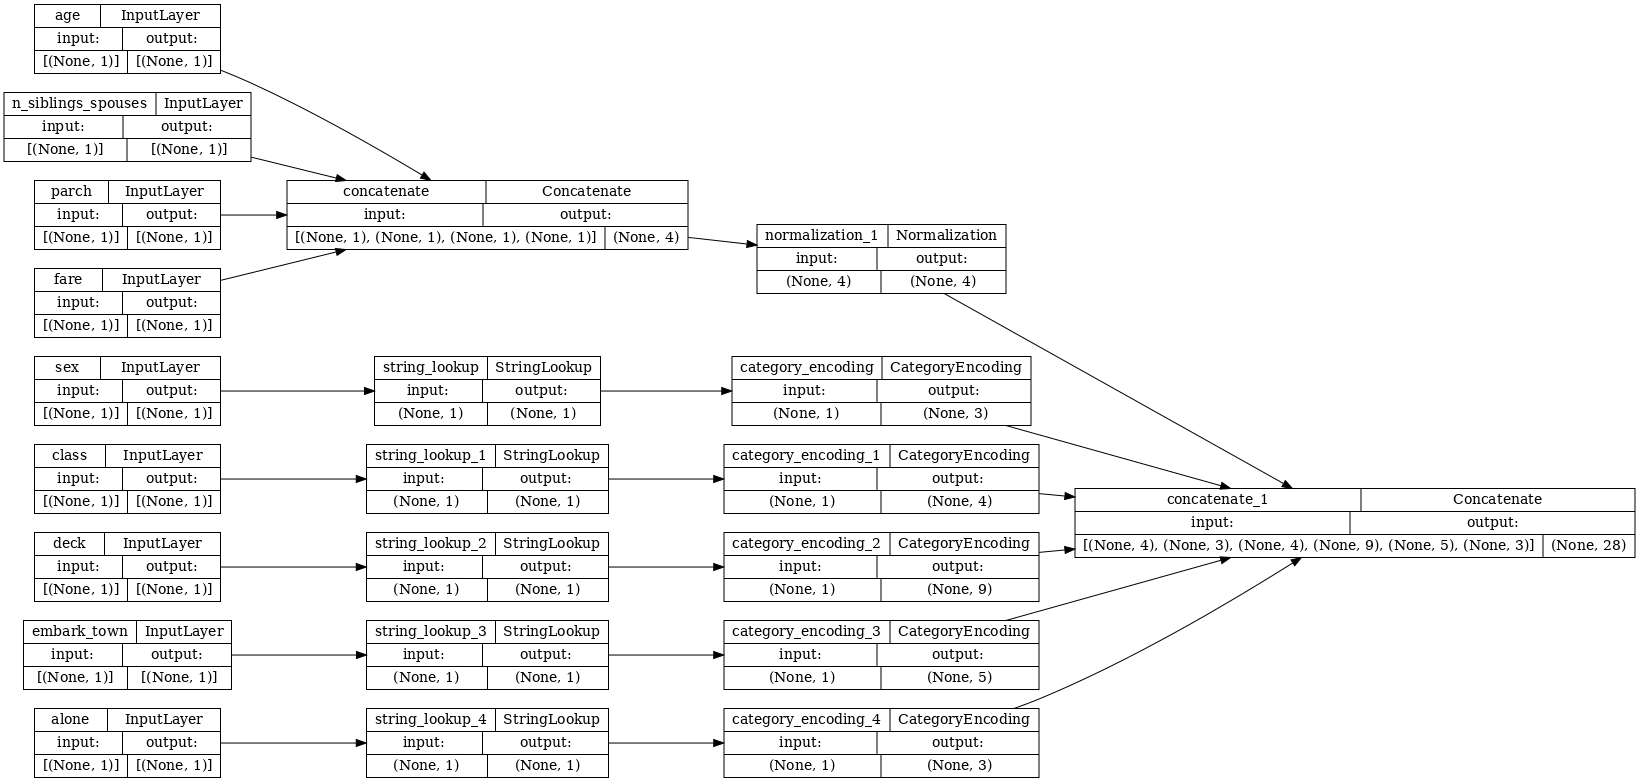

In [20]:
preprocessed_inputs_cat = layers.Concatenate()(preprocessed_inputs)

titanic_preprocessing = tf.keras.Model(inputs, preprocessed_inputs_cat)

tf.keras.utils.plot_model(model = titanic_preprocessing , rankdir="LR", dpi=72, show_shapes=True)

此 `model` 仅包含输入预处理。您可以运行它以查看其对您的数据进行了哪些操作。Keras 模型不会自动转换 Pandas <code>DataFrames</code>，因为不清楚是应该将其转换为一个张量还是张量字典。因此，将其转换为张量字典：

In [21]:
titanic_features_dict = {name: np.array(value) 
                         for name, value in titanic_features.items()}

切出第一个训练样本并将其传递给此预处理模型，您会看到数字特征和字符串独热全部串联在一起：

In [22]:
features_dict = {name:values[:1] for name, values in titanic_features_dict.items()}
titanic_preprocessing(features_dict)

<tf.Tensor: shape=(1, 28), dtype=float32, numpy=
array([[-0.61 ,  0.395, -0.479, -0.497,  0.   ,  0.   ,  1.   ,  0.   ,
         0.   ,  0.   ,  1.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,
         0.   ,  0.   ,  0.   ,  1.   ,  0.   ,  0.   ,  0.   ,  1.   ,
         0.   ,  0.   ,  1.   ,  0.   ]], dtype=float32)>

接下来，在此基础上构建模型：

In [23]:
def titanic_model(preprocessing_head, inputs):
  body = tf.keras.Sequential([
    layers.Dense(64),
    layers.Dense(1)
  ])

  preprocessed_inputs = preprocessing_head(inputs)
  result = body(preprocessed_inputs)
  model = tf.keras.Model(inputs, result)

  model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                optimizer=tf.keras.optimizers.Adam())
  return model

titanic_model = titanic_model(titanic_preprocessing, inputs)

训练模型时，将特征字典作为 `x` 传递，将标签作为 `y` 传递。

In [24]:
titanic_model.fit(x=titanic_features_dict, y=titanic_labels, epochs=10)

Epoch 1/10



 1/20 [>.............................] - ETA: 30s - loss: 0.6159


13/20 [==================>...........] - ETA: 0s - loss: 0.5816 


20/20 [==============================] - 2s 4ms/step - loss: 0.5669


Epoch 2/10



 1/20 [>.............................] - ETA: 0s - loss: 0.4976


14/20 [====================>.........] - ETA: 0s - loss: 0.5234


20/20 [==============================] - 0s 4ms/step - loss: 0.5039


Epoch 3/10



 1/20 [>.............................] - ETA: 0s - loss: 0.5891


15/20 [=====================>........] - ETA: 0s - loss: 0.4731


20/20 [==============================] - 0s 4ms/step - loss: 0.4748


Epoch 4/10



 1/20 [>.............................] - ETA: 0s - loss: 0.4022


14/20 [====================>.........] - ETA: 0s - loss: 0.4678


20/20 [==============================] - 0s 4ms/step - loss: 0.4562


Epoch 5/10



 1/20 [>.............................] - ETA: 0s - loss: 0.3903


14/20 [====================>.........] - ETA: 0s - loss: 0.4497


20/20 [==============================] - 0s 4ms/step - loss: 0.4436


Epoch 6/10



 1/20 [>.............................] - ETA: 0s - loss: 0.3655


14/20 [====================>.........] - ETA: 0s - loss: 0.4231


20/20 [==============================] - 0s 4ms/step - loss: 0.4357


Epoch 7/10



 1/20 [>.............................] - ETA: 0s - loss: 0.3896


14/20 [====================>.........] - ETA: 0s - loss: 0.4154


20/20 [==============================] - 0s 4ms/step - loss: 0.4293


Epoch 8/10



 1/20 [>.............................] - ETA: 0s - loss: 0.4782


14/20 [====================>.........] - ETA: 0s - loss: 0.4362


20/20 [==============================] - 0s 4ms/step - loss: 0.4253


Epoch 9/10



 1/20 [>.............................] - ETA: 0s - loss: 0.4934


14/20 [====================>.........] - ETA: 0s - loss: 0.4070


20/20 [==============================] - 0s 4ms/step - loss: 0.4244


Epoch 10/10



 1/20 [>.............................] - ETA: 0s - loss: 0.3007


14/20 [====================>.........] - ETA: 0s - loss: 0.4141


20/20 [==============================] - 0s 4ms/step - loss: 0.4222


由于预处理是模型的一部分，您可以保存模型并将其重新加载到其他地方并获得相同的结果：

In [25]:
titanic_model.save('test')
reloaded = tf.keras.models.load_model('test')

INFO:tensorflow:Assets written to: test/assets


INFO:tensorflow:Assets written to: test/assets


In [26]:
features_dict = {name:values[:1] for name, values in titanic_features_dict.items()}

before = titanic_model(features_dict)
after = reloaded(features_dict)
assert (before-after)<1e-3
print(before)
print(after)

tf.Tensor([[-1.899]], shape=(1, 1), dtype=float32)
tf.Tensor([[-1.899]], shape=(1, 1), dtype=float32)


## 使用 tf.data


在前一部分中，您在训练模型时依赖了模型的内置数据乱序和批处理。

如果您需要对输入数据流水线进行更多控制或需要使用不易放入内存的数据：请使用 `tf.data`。

有关更多示例，请参阅 [`tf.data`：构建 TensorFlow 输入流水线](../../guide/data.ipynb)指南。

### 有关内存数据

作为将 `tf.data` 应用于 CSV 数据的第一个样本，请考虑使用以下代码手动切分上一个部分中的特征字典。对于每个索引，它会为每个特征获取该索引：


In [27]:
import itertools

def slices(features):
  for i in itertools.count():
    # For each feature take index `i`
    example = {name:values[i] for name, values in features.items()}
    yield example

运行此代码并打印第一个样本：

In [28]:
for example in slices(titanic_features_dict):
  for name, value in example.items():
    print(f"{name:19s}: {value}")
  break

sex                : male
age                : 22.0
n_siblings_spouses : 1
parch              : 0
fare               : 7.25
class              : Third
deck               : unknown
embark_town        : Southampton
alone              : n


内存数据加载程序中最基本的 `tf.data.Dataset` 是 `Dataset.from_tensor_slices` 构造函数。这会返回一个 `tf.data.Dataset`，它将在 TensorFlow 中实现上述 `slices` 函数的泛化版本。

In [29]:
features_ds = tf.data.Dataset.from_tensor_slices(titanic_features_dict)

您可以像任何其他 Python 可迭代对象一样迭代 `tf.data.Dataset`：

In [30]:
for example in features_ds:
  for name, value in example.items():
    print(f"{name:19s}: {value}")
  break

sex                : b'male'
age                : 22.0
n_siblings_spouses : 1
parch              : 0
fare               : 7.25
class              : b'Third'
deck               : b'unknown'
embark_town        : b'Southampton'
alone              : b'n'


`from_tensor_slices` 函数可以处理嵌套字典或元组的任何结构。以下代码创建了一个 `(features_dict, labels)` 对的数据集：

In [31]:
titanic_ds = tf.data.Dataset.from_tensor_slices((titanic_features_dict, titanic_labels))

要使用此 `Dataset` 训练模型，您至少需要对数据进行 `shuffle` 和 `batch`。

In [32]:
titanic_batches = titanic_ds.shuffle(len(titanic_labels)).batch(32)

不是将 `features` 和 `labels` 传递给 `Model.fit`，而是传递数据集：

In [33]:
titanic_model.fit(titanic_batches, epochs=5)

Epoch 1/5



 1/20 [>.............................] - ETA: 7s - loss: 0.2701


14/20 [====================>.........] - ETA: 0s - loss: 0.4223


20/20 [==============================] - 0s 4ms/step - loss: 0.4209


Epoch 2/5



 1/20 [>.............................] - ETA: 0s - loss: 0.2889


15/20 [=====================>........] - ETA: 0s - loss: 0.4129


20/20 [==============================] - 0s 4ms/step - loss: 0.4204


Epoch 3/5



 1/20 [>.............................] - ETA: 0s - loss: 0.4769


15/20 [=====================>........] - ETA: 0s - loss: 0.4060


20/20 [==============================] - 0s 4ms/step - loss: 0.4205


Epoch 4/5



 1/20 [>.............................] - ETA: 0s - loss: 0.5053


14/20 [====================>.........] - ETA: 0s - loss: 0.4209


20/20 [==============================] - 0s 4ms/step - loss: 0.4205


Epoch 5/5



 1/20 [>.............................] - ETA: 0s - loss: 0.5134


14/20 [====================>.........] - ETA: 0s - loss: 0.4280


20/20 [==============================] - 0s 4ms/step - loss: 0.4193


### 从单个文件

到目前为止，本教程已经使用了内存数据。`tf.data` 是用于构建数据流水线的高度可扩展的工具包，并提供了一些用于处理加载 CSV 文件的函数。 

In [34]:
titanic_file_path = tf.keras.utils.get_file("train.csv", "https://storage.googleapis.com/tf-datasets/titanic/train.csv")


 8192/30874 [======>.......................] - ETA: 0s


30874/30874 [==============================] - 0s 0us/step


现在，从文件中读取 CSV 数据并创建一个 `tf.data.Dataset`。

（有关完整文档，请参阅 `tf.data.experimental.make_csv_dataset`）


In [35]:
titanic_csv_ds = tf.data.experimental.make_csv_dataset(
    titanic_file_path,
    batch_size=5, # Artificially small to make examples easier to show.
    label_name='survived',
    num_epochs=1,
    ignore_errors=True,)

Instructions for updating:
Use `tf.data.Dataset.ignore_errors` instead.


Instructions for updating:
Use `tf.data.Dataset.ignore_errors` instead.


此函数包括许多方便的功能，因此很容易处理数据。这包括:

- 使用列标题作为字典键。
- 自动确定每列的类型。

小心：请确保在 `tf.data.experimental.make_csv_dataset` 中设置 `num_epochs` 参数，否则 `tf.data.Dataset` 的默认行为是无限循环。

In [36]:
for batch, label in titanic_csv_ds.take(1):
  for key, value in batch.items():
    print(f"{key:20s}: {value}")
  print()
  print(f"{'label':20s}: {label}")

sex                 : [b'female' b'female' b'male' b'male' b'male']
age                 : [50. 31. 28. 28. 28.]
n_siblings_spouses  : [0 0 1 0 0]
parch               : [0 0 2 0 0]
fare                : [28.712  7.854 23.45  56.496  7.896]
class               : [b'First' b'Third' b'Third' b'Third' b'Third']
deck                : [b'C' b'unknown' b'unknown' b'unknown' b'unknown']
embark_town         : [b'Cherbourg' b'Southampton' b'Southampton' b'Southampton' b'Southampton']
alone               : [b'y' b'y' b'n' b'y' b'y']

label               : [0 0 0 0 0]


注：如果您运行两次上述代码单元，它将产生不同的结果。`tf.data.experimental.make_csv_dataset` 的默认设置包括 `shuffle_buffer_size=1000`，这对于这个小型数据集来说已经绰绰有余，但可能不适用于实际的数据集。

它还可以对数据进行即时解压。下面是一个用 gzip 压缩的 CSV 文件，其中包含 [Metro Interstate Traffic Dataset](https://archive.ics.uci.edu/ml/datasets/Metro+Interstate+Traffic+Volume)。

![交通堵塞。](images/csv/traffic.jpg)

图片[来自 Wikimedia](https://commons.wikimedia.org/wiki/File:Trafficjam.jpg)


In [37]:
traffic_volume_csv_gz = tf.keras.utils.get_file(
    'Metro_Interstate_Traffic_Volume.csv.gz', 
    "https://archive.ics.uci.edu/ml/machine-learning-databases/00492/Metro_Interstate_Traffic_Volume.csv.gz",
    cache_dir='.', cache_subdir='traffic')


   8192/Unknown - 0s 0us/step

将 `compression_type` 参数设置为直接从压缩文件中读取：

In [38]:
traffic_volume_csv_gz_ds = tf.data.experimental.make_csv_dataset(
    traffic_volume_csv_gz,
    batch_size=256,
    label_name='traffic_volume',
    num_epochs=1,
    compression_type="GZIP")

for batch, label in traffic_volume_csv_gz_ds.take(1):
  for key, value in batch.items():
    print(f"{key:20s}: {value[:5]}")
  print()
  print(f"{'label':20s}: {label[:5]}")

holiday             : [b'None' b'None' b'None' b'None' b'None']
temp                : [256.34 296.9  268.41 289.85 266.65]
rain_1h             : [0. 0. 0. 0. 0.]
snow_1h             : [0. 0. 0. 0. 0.]
clouds_all          : [90 80  1  0 90]
weather_main        : [b'Clouds' b'Mist' b'Clear' b'Clear' b'Clouds']
weather_description : [b'overcast clouds' b'mist' b'sky is clear' b'Sky is Clear'
 b'overcast clouds']
date_time           : [b'2013-01-14 07:00:00' b'2013-08-30 08:00:00' b'2013-02-09 17:00:00'
 b'2013-09-12 09:00:00' b'2012-12-17 19:00:00']

label               : [6579 6042 4374 5687 2953]


注：如果需要在 `tf.data` 流水线中解析这些日期时间字符串，您可以使用 `tfa.text.parse_time`。

### 缓存

解析 CSV 数据有一些开销。对于小型模型，这可能是训练的瓶颈。

根据您的用例，使用 `Dataset.cache` 或 `tf.data.Dataset.snapshot` 可能是个好主意，这样 CSV 数据仅会在第一个周期进行解析。

`cache` 和 `snapshot` 方法的主要区别在于 `cache` 文件只能由创建它们的 TensorFlow 进程使用，而 `snapshot` 文件可以被其他进程读取。

例如，在没有缓存的情况下迭代 `traffic_volume_csv_gz_ds` 20 次可能需要大约 15 秒，而使用缓存大约需要 2 秒。

In [39]:
%%time
for i, (batch, label) in enumerate(traffic_volume_csv_gz_ds.repeat(20)):
  if i % 40 == 0:
    print('.', end='')
print()

..

..

..

..

..

..

...

..

..

..

..

..

..

..

..

...

..

..

..

...

..

...

..

..

..

..

..

..

..

..

...

..

..

...

..

..

...

..

...

..

..

..

..

.
CPU times: user 15 s, sys: 2.52 s, total: 17.5 s
Wall time: 11.3 s


注：`Dataset.cache` 会存储第一个周期的数据并按顺序回放。因此，使用 `cache` 方法会禁用流水线中较早的任何乱序内容。下面，在 `Dataset.cache` 之后重新添加了 `Dataset.shuffle`。

In [40]:
%%time
caching = traffic_volume_csv_gz_ds.cache().shuffle(1000)

for i, (batch, label) in enumerate(caching.shuffle(1000).repeat(20)):
  if i % 40 == 0:
    print('.', end='')
print()

................

................

.................

................

................

..............
CPU times: user 1.9 s, sys: 285 ms, total: 2.19 s
Wall time: 1.87 s


注：`tf.data.Dataset.snapshot` 文件用于在使用时*临时*存储数据集。这*不是*长期存储的格式。文件格式被视为内部详细信息，无法在 TensorFlow 各版本之间保证。

In [41]:
%%time
snapshotting = traffic_volume_csv_gz_ds.snapshot('titanic.tfsnap').shuffle(1000)

for i, (batch, label) in enumerate(snapshotting.shuffle(1000).repeat(20)):
  if i % 40 == 0:
    print('.', end='')
print()

.............

.............

................

................

................

................

.....
CPU times: user 2.68 s, sys: 738 ms, total: 3.42 s
Wall time: 2.12 s


如果加载 CSV 文件减慢了数据加载速度，并且 `Dataset.cache` 和 `tf.data.Dataset.snapshot` 不足以满足您的用例，请考虑将数据重新编码为更简化的格式。

### 多个文件

到目前为止，本部分中的所有示例都可以在没有 `tf.data` 的情况下轻松完成。处理文件集合时，`tf.data` 可以真正简化事情。

例如，将 [Character Font Images](https://archive.ics.uci.edu/ml/datasets/Character+Font+Images) 数据集作为 CSV 文件的集合分发，每种字体一个集合。

![字体](images/csv/fonts.jpg)

图像作者：<a href="https://pixabay.com/users/wilhei-883152/?utm_source=link-attribution&amp;utm_medium=referral&amp;utm_campaign=image&amp;utm_content=705667">Willi Heidelbach</a>，来源：<a href="https://pixabay.com/?utm_source=link-attribution&amp;utm_medium=referral&amp;utm_campaign=image&amp;utm_content=705667">Pixabay</a>

下载数据集，并查看里面的文件：

In [42]:
fonts_zip = tf.keras.utils.get_file(
    'fonts.zip',  "https://archive.ics.uci.edu/ml/machine-learning-databases/00417/fonts.zip",
    cache_dir='.', cache_subdir='fonts',
    extract=True)


   8192/Unknown - 0s 0us/step

In [43]:
import pathlib
font_csvs =  sorted(str(p) for p in pathlib.Path('fonts').glob("*.csv"))

font_csvs[:10]

['fonts/AGENCY.csv',
 'fonts/ARIAL.csv',
 'fonts/BAITI.csv',
 'fonts/BANKGOTHIC.csv',
 'fonts/BASKERVILLE.csv',
 'fonts/BAUHAUS.csv',
 'fonts/BELL.csv',
 'fonts/BERLIN.csv',
 'fonts/BERNARD.csv',
 'fonts/BITSTREAMVERA.csv']

In [44]:
len(font_csvs)

153

在处理一堆文件时，可以将 glob 样式的 `file_pattern` 传递给 `tf.data.experimental.make_csv_dataset` 函数。每次迭代都会打乱文件的顺序。

使用 `num_parallel_reads` 参数对并行读取多少文件并交错在一起进行设置。

In [45]:
fonts_ds = tf.data.experimental.make_csv_dataset(
    file_pattern = "fonts/*.csv",
    batch_size=10, num_epochs=1,
    num_parallel_reads=20,
    shuffle_buffer_size=10000)

这些 CSV 文件会将图像展平成一行。列名的格式为 `r{row}c{column}`。下面是第一个批次：

In [46]:
for features in fonts_ds.take(1):
  for i, (name, value) in enumerate(features.items()):
    if i>15:
      break
    print(f"{name:20s}: {value}")
print('...')
print(f"[total: {len(features)} features]")

font                : [b'BASKERVILLE' b'RAGE' b'COMPLEX' b'MISTRAL' b'COUNTRYBLUEPRINT'
 b'SWIS721' b'RICHARD' b'STYLUS' b'SWIS721' b'SWIS721']
fontVariant         : [b'BASKERVILLE OLD FACE' b'RAGE ITALIC' b'COMPLEX' b'MISTRAL'
 b'COUNTRYBLUEPRINT' b'SWIS721 LTEX BT' b'POOR RICHARD' b'STYLUS BT'
 b'SWIS721 LTEX BT' b'SWIS721 LTEX BT']
m_label             : [  68  111 9578  383 8225  126   92   93  376  382]
strength            : [0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4]
italic              : [1 0 0 0 0 0 0 0 1 0]
orientation         : [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
m_top               : [34 55 28 29 38 60 29 38 23 34]
m_left              : [22 20 25 25 24 26 21 20 37 22]
originalH           : [45 21 74 49 54  9 60 54 61 50]
originalW           : [55 21 38 14 25 44 39 12 47 33]
h                   : [20 20 20 20 20 20 20 20 20 20]
w                   : [20 20 20 20 20 20 20 20 20 20]
r0c0                : [  1   1   1   1 255   1 168 161   1   1]
r0c1                : [  1   1   1   1 

...
[total: 412 features]


#### 可选：打包字段

您可能不想像这样在单独的列中处理每个像素。在尝试使用此数据集之前，请务必将像素打包到图像张量中。

下面是解析列名，从而为每个示例构建图像的代码：

In [47]:
import re

def make_images(features):
  image = [None]*400
  new_feats = {}

  for name, value in features.items():
    match = re.match('r(\d+)c(\d+)', name)
    if match:
      image[int(match.group(1))*20+int(match.group(2))] = value
    else:
      new_feats[name] = value

  image = tf.stack(image, axis=0)
  image = tf.reshape(image, [20, 20, -1])
  new_feats['image'] = image

  return new_feats

将该函数应用于数据集中的每个批次：

In [48]:
fonts_image_ds = fonts_ds.map(make_images)

for features in fonts_image_ds.take(1):
  break

绘制生成的图像：

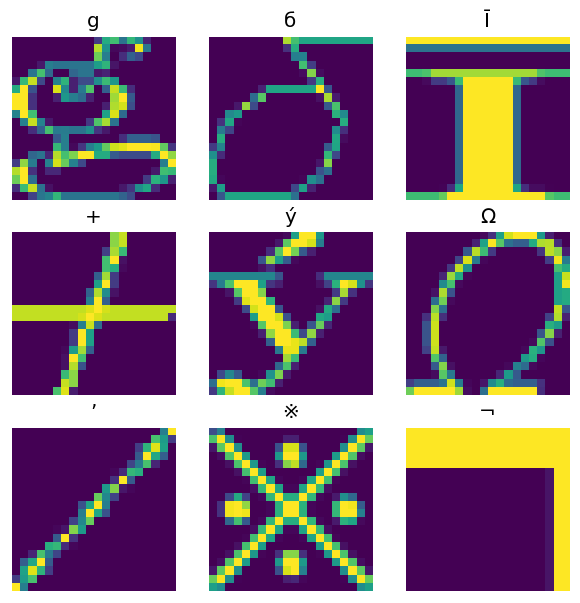

In [49]:
from matplotlib import pyplot as plt

plt.figure(figsize=(6,6), dpi=120)

for n in range(9):
  plt.subplot(3,3,n+1)
  plt.imshow(features['image'][..., n])
  plt.title(chr(features['m_label'][n]))
  plt.axis('off')

## 低级函数

到目前为止，本教程重点介绍了用于读取 CSV 数据的最高级别实用程序。如果您的用例不符合基本模式，还有其他两个 API 可能对高级用户有所帮助。

- `tf.io.decode_csv`：用于将文本行解析为 CSV 列张量列表的函数。
- `tf.data.experimental.CsvDataset`：较低级别的 CSV 数据集构造函数。

本部分会重新创建 `tf.data.experimental.make_csv_dataset` 提供的功能，以演示如何使用此较低级别的功能。


### `tf.io.decode_csv`

此函数会将字符串或字符串列表解码为列列表。

与 `tf.data.experimental.make_csv_dataset` 不同，此函数不会尝试猜测列数据类型。您可以通过为每列提供包含正确类型值的记录 `record_defaults` 值列表来指定列类型。

要使用 <code>tf.io.decode_csv</code> 将 Titanic 数据<strong>作为字符串</strong>读取，您可以使用以下代码：

In [50]:
text = pathlib.Path(titanic_file_path).read_text()
lines = text.split('\n')[1:-1]

all_strings = [str()]*10
all_strings

['', '', '', '', '', '', '', '', '', '']

In [51]:
features = tf.io.decode_csv(lines, record_defaults=all_strings) 

for f in features:
  print(f"type: {f.dtype.name}, shape: {f.shape}")

type: string, shape: (627,)
type: string, shape: (627,)
type: string, shape: (627,)
type: string, shape: (627,)
type: string, shape: (627,)
type: string, shape: (627,)
type: string, shape: (627,)
type: string, shape: (627,)
type: string, shape: (627,)
type: string, shape: (627,)


要使用它们的实际类型解析它们，请创建相应类型的 `record_defaults` 列表： 

In [52]:
print(lines[0])

0,male,22.0,1,0,7.25,Third,unknown,Southampton,n


In [53]:
titanic_types = [int(), str(), float(), int(), int(), float(), str(), str(), str(), str()]
titanic_types

[0, '', 0.0, 0, 0, 0.0, '', '', '', '']

In [54]:
features = tf.io.decode_csv(lines, record_defaults=titanic_types) 

for f in features:
  print(f"type: {f.dtype.name}, shape: {f.shape}")

type: int32, shape: (627,)
type: string, shape: (627,)
type: float32, shape: (627,)
type: int32, shape: (627,)
type: int32, shape: (627,)
type: float32, shape: (627,)
type: string, shape: (627,)
type: string, shape: (627,)
type: string, shape: (627,)
type: string, shape: (627,)


注：在大批量行上调用 `tf.io.decode_csv` 比在单个 CSV 文本行上调用更有效。

### `tf.data.experimental.CsvDataset`

`tf.data.experimental.CsvDataset` 类提供了一个最小的 CSV `Dataset` 接口，没有 `tf.data.experimental.make_csv_dataset` 函数的便利功能：列标题解析、列类型推断、自动乱序、文件交错。

此构造函数使用 `record_defaults` 的方式与 `tf.io.decode_csv` 相同：


In [55]:
simple_titanic = tf.data.experimental.CsvDataset(titanic_file_path, record_defaults=titanic_types, header=True)

for example in simple_titanic.take(1):
  print([e.numpy() for e in example])

[0, b'male', 22.0, 1, 0, 7.25, b'Third', b'unknown', b'Southampton', b'n']


上面的代码基本等价于：

In [56]:
def decode_titanic_line(line):
  return tf.io.decode_csv(line, titanic_types)

manual_titanic = (
    # Load the lines of text
    tf.data.TextLineDataset(titanic_file_path)
    # Skip the header row.
    .skip(1)
    # Decode the line.
    .map(decode_titanic_line)
)

for example in manual_titanic.take(1):
  print([e.numpy() for e in example])

[0, b'male', 22.0, 1, 0, 7.25, b'Third', b'unknown', b'Southampton', b'n']


#### 多个文件

要使用 `tf.data.experimental.CsvDataset` 解析字体数据集，您首先需要确定 `record_defaults` 的列类型。首先检查一个文件的第一行：

In [57]:
font_line = pathlib.Path(font_csvs[0]).read_text().splitlines()[1]
print(font_line)

AGENCY,AGENCY FB,64258,0.400000,0,0.000000,35,21,51,22,20,20,1,1,1,21,101,210,255,255,255,255,255,255,255,255,255,255,255,255,255,255,1,1,1,93,255,255,255,176,146,146,146,146,146,146,146,146,216,255,255,255,1,1,1,93,255,255,255,70,1,1,1,1,1,1,1,1,163,255,255,255,1,1,1,93,255,255,255,70,1,1,1,1,1,1,1,1,163,255,255,255,1,1,1,93,255,255,255,70,1,1,1,1,1,1,1,1,163,255,255,255,1,1,1,93,255,255,255,70,1,1,1,1,1,1,1,1,163,255,255,255,1,1,1,93,255,255,255,70,1,1,1,1,1,1,1,1,163,255,255,255,141,141,141,182,255,255,255,172,141,141,141,115,1,1,1,1,163,255,255,255,255,255,255,255,255,255,255,255,255,255,255,209,1,1,1,1,163,255,255,255,6,6,6,96,255,255,255,74,6,6,6,5,1,1,1,1,163,255,255,255,1,1,1,93,255,255,255,70,1,1,1,1,1,1,1,1,163,255,255,255,1,1,1,93,255,255,255,70,1,1,1,1,1,1,1,1,163,255,255,255,1,1,1,93,255,255,255,70,1,1,1,1,1,1,1,1,163,255,255,255,1,1,1,93,255,255,255,70,1,1,1,1,1,1,1,1,163,255,255,255,1,1,1,93,255,255,255,70,1,1,1,1,1,1,1,1,163,255,255,255,1,1,1,93,255,255,255,70,1,1,1,1,1

只有前两个字段是字符串，其余的都是整数或浮点数，通过计算逗号的个数可以得到特征总数：

In [58]:
num_font_features = font_line.count(',')+1
font_column_types = [str(), str()] + [float()]*(num_font_features-2)

`tf.data.experimental.CsvDataset` 构造函数可以获取输入文件列表，但会按顺序读取它们。CSV 列表中的第一个文件是 `AGENCY.csv`：

In [59]:
font_csvs[0]

'fonts/AGENCY.csv'

因此，当您将文件列表传递给 `CsvDataset` 时，会首先读取 `AGENCY.csv` 中的记录：

In [60]:
simple_font_ds = tf.data.experimental.CsvDataset(
    font_csvs, 
    record_defaults=font_column_types, 
    header=True)

In [61]:
for row in simple_font_ds.take(10):
  print(row[0].numpy())

b'AGENCY'
b'AGENCY'
b'AGENCY'
b'AGENCY'
b'AGENCY'
b'AGENCY'
b'AGENCY'
b'AGENCY'
b'AGENCY'
b'AGENCY'


要交错多个文件，请使用 `Dataset.interleave`。

这是一个包含 CSV 文件名的初始数据集： 

In [62]:
font_files = tf.data.Dataset.list_files("fonts/*.csv")

这会在每个周期对文件名进行乱序：

In [63]:
print('Epoch 1:')
for f in list(font_files)[:5]:
  print("    ", f.numpy())
print('    ...')
print()

print('Epoch 2:')
for f in list(font_files)[:5]:
  print("    ", f.numpy())
print('    ...')

Epoch 1:
     b'fonts/TEMPUS.csv'
     b'fonts/PERPETUA.csv'
     b'fonts/KRISTEN.csv'
     b'fonts/MISTRAL.csv'
     b'fonts/CENTURY.csv'
    ...

Epoch 2:


     b'fonts/OCRB.csv'
     b'fonts/ARIAL.csv'
     b'fonts/STYLUS.csv'
     b'fonts/TIMES.csv'
     b'fonts/BOOK.csv'
    ...


`interleave` 方法采用 `map_func`，它会为父 `Dataset`的每个元素创建一个子 `Dataset`。

在这里，您要从文件数据集的每个元素创建一个 `tf.data.experimental.CsvDataset`：

In [64]:
def make_font_csv_ds(path):
  return tf.data.experimental.CsvDataset(
    path, 
    record_defaults=font_column_types, 
    header=True)

交错返回的 `Dataset` 通过循环遍历多个子 `Dataset` 来返回元素。请注意，下面的数据集如何在 `cycle_length=3` 三个字体文件中循环：

In [65]:
font_rows = font_files.interleave(make_font_csv_ds,
                                  cycle_length=3)

In [66]:
fonts_dict = {'font_name':[], 'character':[]}

for row in font_rows.take(10):
  fonts_dict['font_name'].append(row[0].numpy().decode())
  fonts_dict['character'].append(chr(row[2].numpy()))

pd.DataFrame(fonts_dict)

/tmpfs/tmp/ipykernel_570970/998453860.py:5: DeprecationWarning: an integer is required (got type numpy.float32).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  fonts_dict['character'].append(chr(row[2].numpy()))


,font_name,character
0,YI BAITI,？
1,GUNPLAY,€
2,BAITI,？
3,YI BAITI,；
4,GUNPLAY,›
5,BAITI,！
6,YI BAITI,：
7,GUNPLAY,‹
8,BAITI,﹈
9,YI BAITI,，


#### 性能


早些时候，有人注意到 `tf.io.decode_csv` 在一个批次字符串上运行时效率更高。

当使用大批量时，可以利用这一事实来提高 CSV 加载性能（但请先尝试使用[缓存](#caching)）。

使用内置加载器 20，2048 个样本批次大约需要 17 秒。 

In [67]:
BATCH_SIZE=2048
fonts_ds = tf.data.experimental.make_csv_dataset(
    file_pattern = "fonts/*.csv",
    batch_size=BATCH_SIZE, num_epochs=1,
    num_parallel_reads=100)

In [68]:
%%time
for i,batch in enumerate(fonts_ds.take(20)):
  print('.',end='')

print()

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


CPU times: user 50.8 s, sys: 4.58 s, total: 55.4 s
Wall time: 23.3 s


将**批量文本行**传递给 `decode_csv` 运行速度更快，大约需要 5 秒：

In [69]:
fonts_files = tf.data.Dataset.list_files("fonts/*.csv")
fonts_lines = fonts_files.interleave(
    lambda fname:tf.data.TextLineDataset(fname).skip(1), 
    cycle_length=100).batch(BATCH_SIZE)

fonts_fast = fonts_lines.map(lambda x: tf.io.decode_csv(x, record_defaults=font_column_types))

In [70]:
%%time
for i,batch in enumerate(fonts_fast.take(20)):
  print('.',end='')

print()

..............

......


CPU times: user 4.21 s, sys: 139 ms, total: 4.35 s
Wall time: 929 ms


有关通过使用大批量提高 CSV 性能的另一个示例，请参阅[过拟合和欠拟合教程](../keras/overfit_and_underfit.ipynb)。

这种方式可能有效，但请考虑其他选项，例如 `Dataset.cache` 和 `tf.data.Dataset.snapshot`，或者将您的数据重新编码为更简化的格式。